In [1]:
# Run this cell only once
!git clone https://github.com/projeto-de-algoritmos/Final_DroneDeliveryScheduler
%cd Final_DroneDeliveryScheduler

Cloning into 'Final_DroneDeliveryScheduler'...
remote: Enumerating objects: 92, done.
remote: Counting objects: 100% (92/92), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 92 (delta 37), reused 72 (delta 22), pack-reused 0
Unpacking objects: 100% (92/92), done.
/content/Final_DroneDeliveryScheduler


In [2]:
import delivery
from delivery.graph_utils import find_shortest_path
from mock_data.data import RandomAerialImageDataGenerator
from delivery.visualization_utils import *

from IPython.display import clear_output, display
import ipywidgets
import operator
from IPython.display import Markdown as md

In [3]:
# initialize the random data generator
random_data_generator = RandomAerialImageDataGenerator(
    width=24*14,
    height=24*14,
    col_size=24,
    row_size=24,
)

In [4]:
slider_maximum_flight_time = ipywidgets.IntSlider(
    value=40, min=10, max=80, step=1
)
slider_num_mav = ipywidgets.IntSlider(
    value=3, min=1, max=5, step=1
)
slider_num_packets = ipywidgets.IntSlider(
    value=2, min=1, max=10, step=1
)

In [5]:
# widgets
update_data_button = ipywidgets.Button(description='UPD DATA')
update_routes_button = ipywidgets.Button(description='UPD ROUTES')

output_map = ipywidgets.Output()
output_map_with_routes = ipywidgets.Output()

In [6]:
def update_random_data(unuseful_arg):
    global data
    # Generate random data.
    data = random_data_generator.generate(
        slider_num_packets.value
    )
    # Plot the generated map (frame grid).
    with output_map:
        clear_output(True)
        plot_frame(
            data.map,
            width=data.map.shape[0],
            height=data.map.shape[1]
        )

In [7]:
COLOR_OPTIONS = [
    # [255,0  ,0  ],  # blue
    [255,255,0  ],  # turquoise
    [255,0  ,255],  # purple
    # [0,  0,  0  ],  # black
    # [0  ,255,0  ],  # green
    # [0  ,0  ,255],  # red
    [255,255,255],  # white
    # [0  ,255,255],  # yellow  
]
tmp_color_options = COLOR_OPTIONS[:]


def update_routes(unuseful_arg):
    # data, params
    global tmp_color_options
    path_list, distance_list = find_shortest_path(
        data.helipad_coord.copy(),
        data.goal_coord_list.copy(),
        data.adj_matrix.copy(),
        data.weight_map.copy()
    )

    frame_to_plot = data.map.copy()

    with output_map_with_routes:
        clear_output(True)
        if len(path_list) > 1:
            for path in path_list:
                if len(tmp_color_options) < 1:
                    tmp_color_options = COLOR_OPTIONS[:]
                color_idx = np.random.choice(len(tmp_color_options))
                color = tmp_color_options[color_idx][:]
                del tmp_color_options[color_idx]
                prev_coord = path[0][:]
                for coord in path[1:]:
                    frame_to_plot = cv2.line(
                        frame_to_plot,
                        (12+prev_coord[1]*random_data_generator.row_size,
                         12+prev_coord[0]*random_data_generator.col_size),
                        (12+coord[1]*random_data_generator.row_size,
                         12+coord[0]*random_data_generator.col_size),
                         color,
                         5
                    )
                    prev_coord = coord[:]
            plot_frame(
                frame_to_plot,
                width=frame_to_plot.shape[0],
                height=frame_to_plot.shape[1]
            )
        else:
            plot_frame(
                frame_to_plot,
                width=frame_to_plot.shape[0],
                height=frame_to_plot.shape[1]
            )
            print('No path found!')

In [8]:
# slider_maximum_flight_time.observe(update_params, names='value')
# slider_num_mav.observe(update_params, names='value')
# slider_num_packets.observe(update_params, names='value')

update_data_button.on_click(update_random_data)
update_routes_button.on_click(update_routes)

In [9]:
# initialize the app
# update_params(unuseful_arg=None)
update_random_data(unuseful_arg=None)
update_routes(unuseful_arg=None)


## **How to use**

There's a button to generate new random data and another one to update the routes. If you generate new data, please wait for the images to show up before pressing the "update routes" button.


"assets/drone_traffic.jpg"

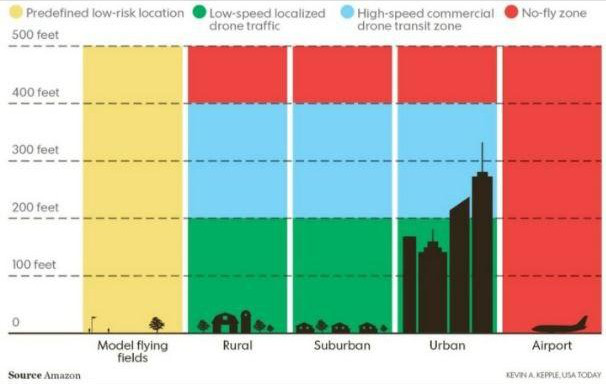

In [10]:
from PIL import Image

Image.open("assets/drone_traffic.jpg")

### **Maximum Flight Time** (minutes)
Maximum flight time of each MAV. We assume that there's only one type of MAV and that every battery lasts the same amount of time.


In [11]:
display(slider_maximum_flight_time)

IntSlider(value=40, max=80, min=10)

### **Number of MAVs**

In [12]:
display(slider_num_mav)

IntSlider(value=3, max=5, min=1)

### **Number of Packets**

In [13]:
display(slider_num_packets)

IntSlider(value=2, max=10, min=1)

### **Update the random image.**


In [14]:
display(update_data_button)

Button(description='UPD DATA', style=ButtonStyle())

### **Update the routes.**


In [15]:
display(update_routes_button)

Button(description='UPD ROUTES', style=ButtonStyle())

### **Random Image**

In [16]:
display(output_map)

Output()

### **Random Image With the Routes of the MAVs**

In [17]:
display(output_map_with_routes)

Output()

In [18]:
def random_normalized_data(shape, min_value, max_value):
    return np.random.random(shape) * (max_value-min_value) + min_value


goal_flight_time_list = random_normalized_data(slider_num_packets.value, 50, 200).round().astype(np.int16)
flight_time = random_normalized_data(1, 50, 200).round().astype(np.int16)
goal_revenue_list = random_normalized_data(slider_num_packets.value, 1, 100).round().astype(np.int16)
uav_quantity = slider_num_mav.value

random_delivery_numbers = random_normalized_data(slider_num_packets.value, 10000, 55000).round().astype(np.int32)
random_delivery_numbers

list_with_revenue_and_delivery_number = []
for i in range(0, len(goal_revenue_list)):
  dictio = {'Delivery Number': random_delivery_numbers[i], 'Revenue': goal_revenue_list[i]}
  list_with_revenue_and_delivery_number.append(dictio)

In [19]:
md(f"# Delivery data: \n ## UAV Quantity: {uav_quantity} \n ## Flight Time: {flight_time} \n ## Goal Revenue List: {goal_revenue_list} \n ##  Goal Flight Time List: {goal_flight_time_list}" )

# Delivery data: 
 ## UAV Quantity: 3 
 ## Flight Time: [52] 
 ## Goal Revenue List: [57 59] 
 ##  Goal Flight Time List: [ 85 118]

In [20]:
def interval_schudeling(uav_quantity, flight_time, goal_flight_time_list, goal_revenue_list):
    total_flight_time_available = uav_quantity * flight_time
    total_delivery_flight_time = sum(goal_flight_time_list)

    if total_delivery_flight_time < total_flight_time_available:
      all = []
      for i in range(0, len(goal_revenue_list)):
        all.append({'Delivery Number': list_with_revenue_and_delivery_number[i]['Delivery Number'],
                    'Revenue': goal_revenue_list[i]})
        
      return all

    revenue_per_time = []
    for i in range(0, len(goal_revenue_list)):
        proportion = float(goal_revenue_list[i]/goal_flight_time_list[i])
        dictio = {'proportion': proportion,
                  'index_at_goal_flight_time_list': i,
                  'Delivery Number': list_with_revenue_and_delivery_number[i]}
        revenue_per_time.append(dictio)

    revenue_per_time.sort(key=operator.itemgetter('proportion'))

    deliveries = []
    aux = 0
    for i in range(len(revenue_per_time)-1, 0, -1):
        if (aux + goal_flight_time_list[revenue_per_time[i]['index_at_goal_flight_time_list']] > total_flight_time_available):
            next
        else:
            aux += goal_flight_time_list[revenue_per_time[i]
                                         ['index_at_goal_flight_time_list']]
            deliveries.append(revenue_per_time[i]['Delivery Number'])

    return deliveries

In [21]:
scheduled_deliveries = interval_schudeling(uav_quantity, flight_time, goal_flight_time_list, goal_revenue_list)
result_string = ""

for delivery in scheduled_deliveries:
  result_string += f"Delivery Number: {delivery['Delivery Number']}  Revenue: {delivery['Revenue']} \n"

print(f"#Scheduled Deliveries: \n{result_string}")

#Scheduled Deliveries: 
Delivery Number: 50454  Revenue: 57 

